<a href="https://colab.research.google.com/github/mgoncerz/SeparationPowerTool/blob/master/automatedTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test settings:

In [0]:
data_file = "data.csv"
csv_delimiter = ','

pearson_coeff_thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]
cutoff_values = [2,3,4,5,6,7,8,9,10,15,20]

columns_to_skip = ['', 'has_MCParticle', 'is_downstream_reconstructible', 'has_MCParticle_not_electron', 'is_downstream_reconstructible_not_electron', 'is_true_seed', 'seed_mva_value']


#use datarow['variable name']
def general_selection(datarow):
  if datarow['has_MCParticle'] == 'True' and datarow['has_MCParticle_not_electron'] == 'True':
    return True
  else:
    return False

def signal_definition(datarow):
  
  if datarow['is_downstream_reconstructible'] == 'True':
    return True
  else:
    return False

Load data:

In [0]:
from csv import DictReader
import numpy

with open(data_file, "r") as datafile:

  datastream = DictReader(datafile)

  variable_names = [name for name in datastream.fieldnames if name not in columns_to_skip]
  signal_data = {name : [] for name in variable_names}
  background_data = {name : [] for name in variable_names}
  print(variable_names)
  #read from file and split into signal and background
  for datarow in datastream:

    if general_selection(datarow):

      if signal_definition(datarow):
        for variable in variable_names:
          signal_data[variable].append(float(datarow[variable]))

      else:
        for variable in variable_names:
          background_data[variable].append(float(datarow[variable]))

  #convert to numpy arrays and normalize
  for variable in variable_names:
    signal_data[variable] = numpy.array(signal_data[variable], dtype=float)
    background_data[variable] = numpy.array(background_data[variable], dtype=float)

    signal_data[variable] = (signal_data[variable] - signal_data[variable].mean()) / signal_data[variable].std()
    background_data[variable] = (background_data[variable] - background_data[variable].mean()) / background_data[variable].std()

['seed_chi2PerDoF', 'seed_p', 'seed_pt', 'seed_nLHCbIDs', 'seed_nbIT', 'seed_nLayers', 'seed_x', 'seed_y', 'seed_tx', 'seed_ty']


Plot normalized data:

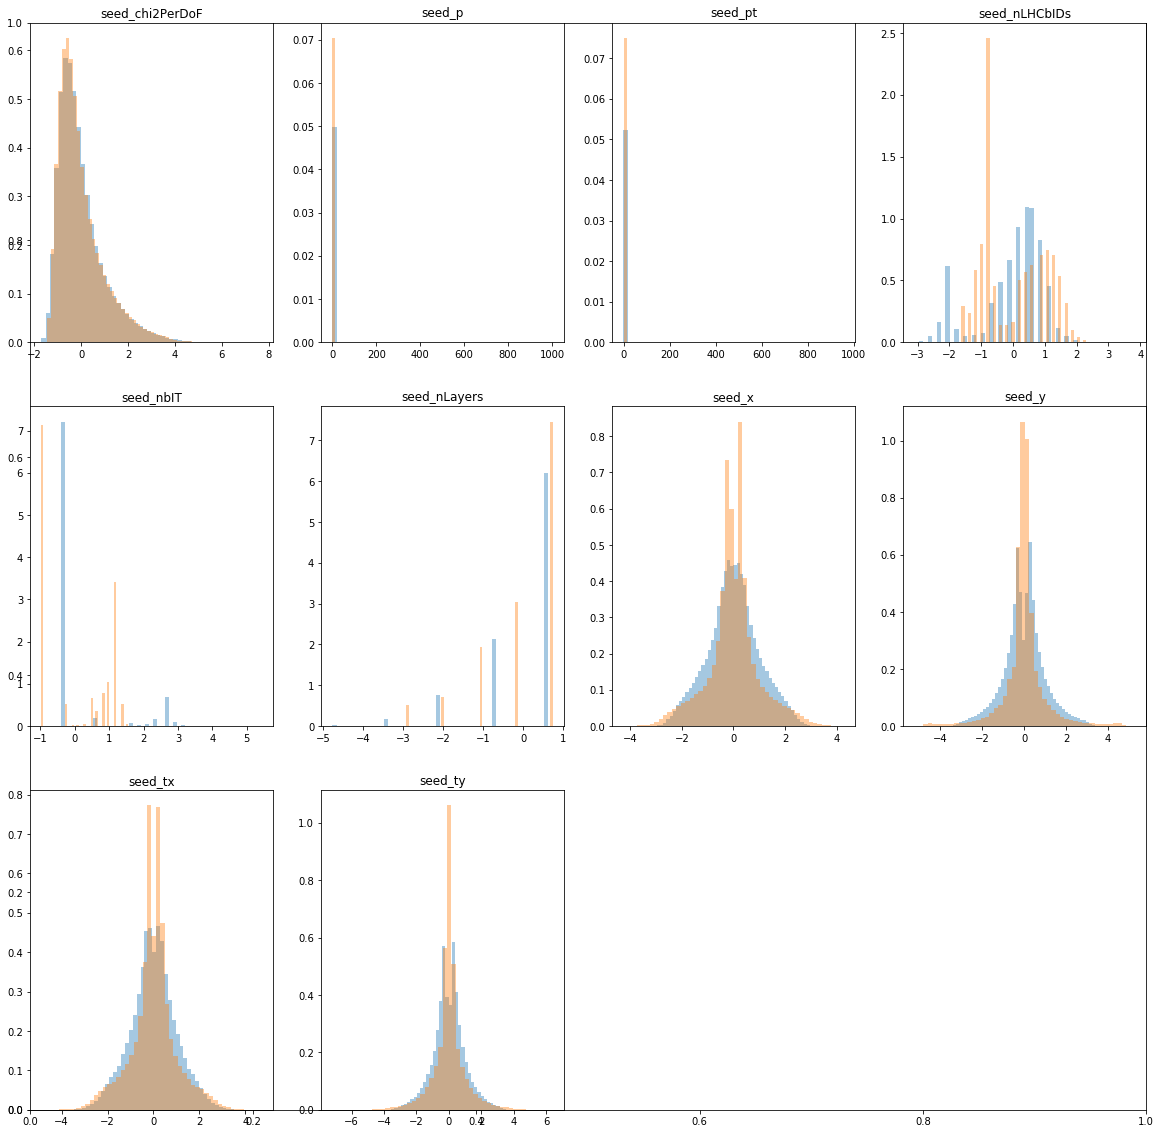

In [0]:
import matplotlib.pyplot as plt
import seaborn
import math

f, ax = plt.subplots(figsize=(20,20))
nrows = math.floor(math.sqrt(len(variable_names)))
ncols = math.ceil(len(variable_names) / nrows)

for index, variable in enumerate(variable_names):
  f.add_subplot(nrows, ncols, index + 1)
  seaborn.distplot(signal_data[variable], kde=False, norm_hist = True).set_title(variable)
  seaborn.distplot(background_data[variable], kde=False, norm_hist = True).set_title(variable)

Calculate separation for each variable and sort:

In [0]:
separation_values = []

for variable in variable_names:

  minimum = min(signal_data[variable].min(), background_data[variable].min())
  maximum = max(signal_data[variable].max(), background_data[variable].max())

  bincontent1, _ = numpy.histogram(signal_data[variable], 1000, range=[minimum,maximum])
  bincontent2, _ = numpy.histogram(background_data[variable], 1000, range=[minimum,maximum])

  separation_values.append(round(100*0.5*sum(map(abs, bincontent1 / sum(bincontent1) - bincontent2 / sum(bincontent2))), 2))

separation_values, variable_names = zip(*sorted(zip(separation_values, variable_names), key=lambda x: x[0], reverse=True))

for sep, var in zip(separation_values, variable_names):
  print([sep, var])

[100.0, 'seed_nLHCbIDs']
[100.0, 'seed_nLayers']
[99.88, 'seed_nbIT']
[31.71, 'seed_y']
[28.41, 'seed_ty']
[19.19, 'seed_x']
[17.6, 'seed_tx']
[13.03, 'seed_pt']
[3.02, 'seed_chi2PerDoF']
[2.25, 'seed_p']


Calculate correlation matrices, indexed by variable position in variable_names:

In [0]:
signal_correlation_matrix = numpy.corrcoef([signal_data[var] for var in variable_names])
background_correlation_matrix = numpy.corrcoef([background_data[var] for var in variable_names])

Plot matrices:

Text(0.5, 1, 'background')

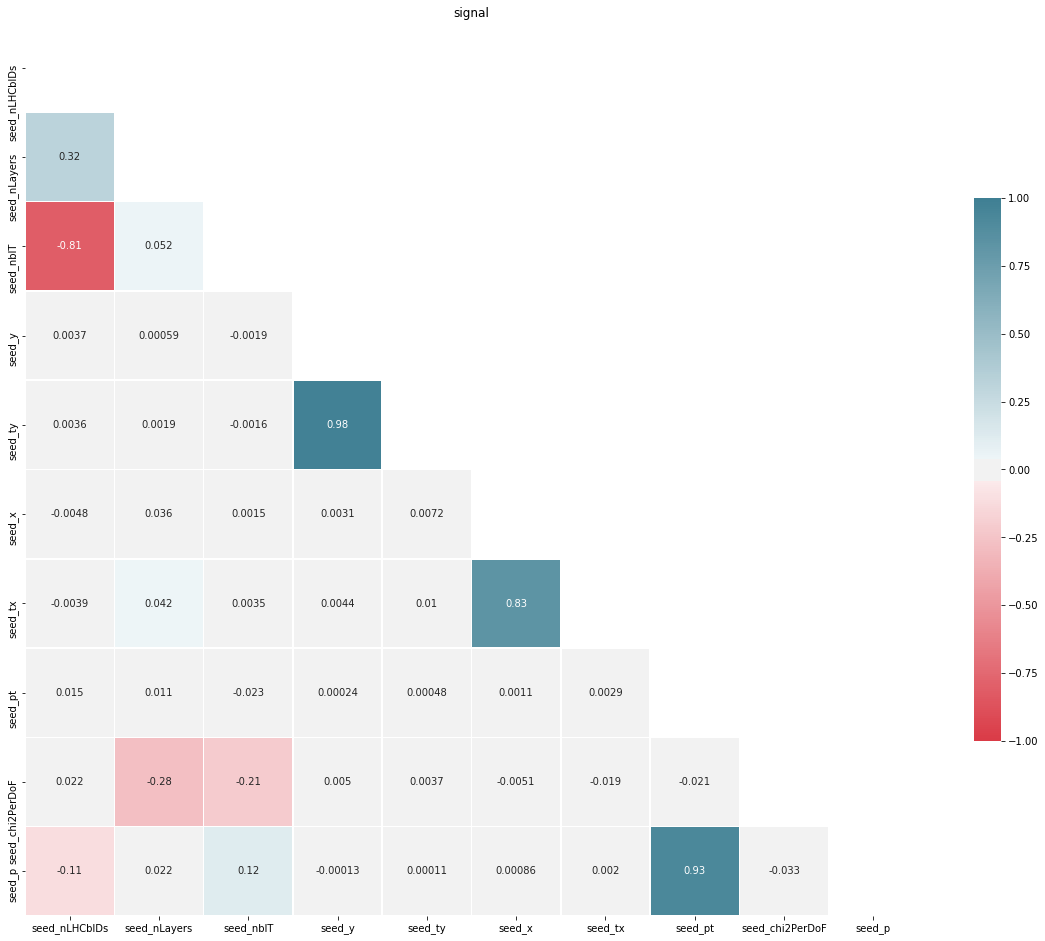

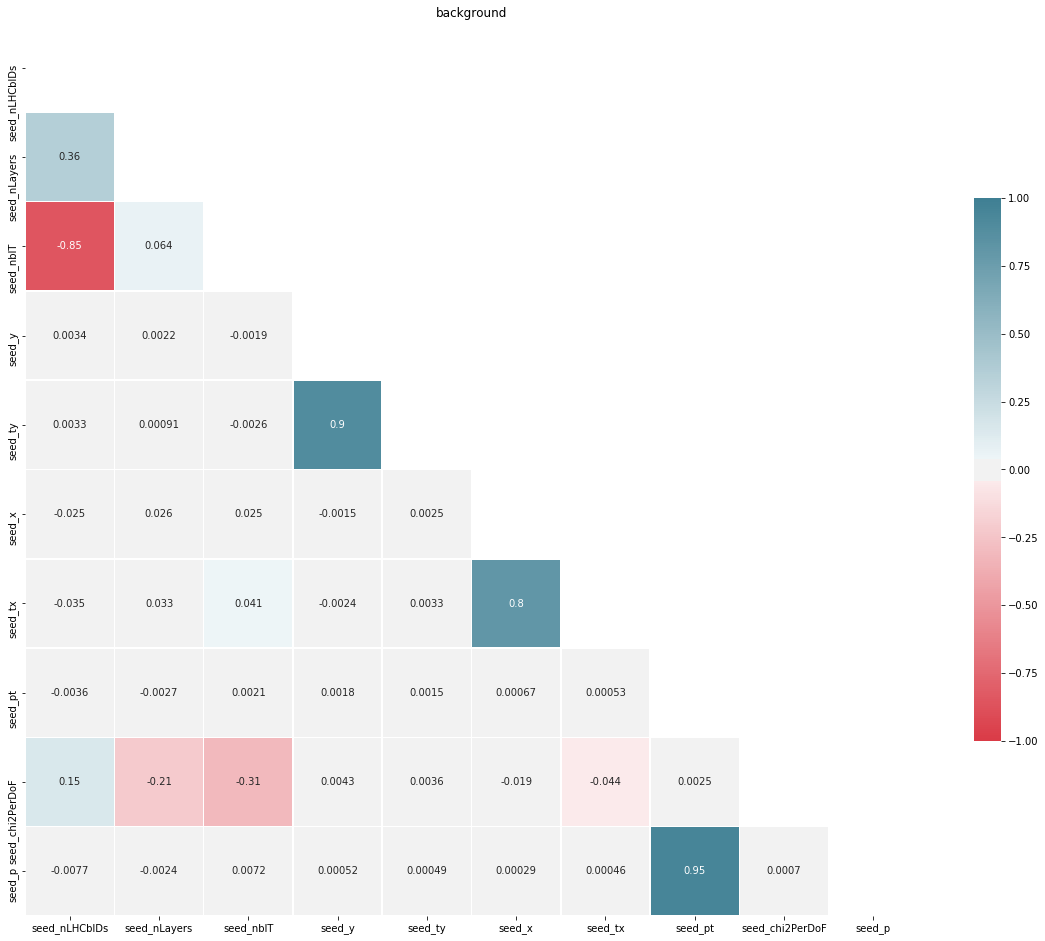

In [0]:
mask = numpy.triu(numpy.ones_like(signal_correlation_matrix, dtype=numpy.bool))
cmap = seaborn.diverging_palette(10, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))
seaborn.heatmap(signal_correlation_matrix, annot=signal_correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels = variable_names, yticklabels = variable_names).set_title('signal')

f, ax = plt.subplots(figsize=(20, 20))
seaborn.heatmap(background_correlation_matrix, annot=background_correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels = variable_names, yticklabels = variable_names).set_title('background')

Generate variable set masks:

In [0]:
masks = []

for pearson in pearson_coeff_thresholds:
  for cutoff in cutoff_values:

    mask = numpy.ones_like(variable_names)

    for lower_sep_index in reversed(range(len(separation_values))):

      if separation_values[lower_sep_index] <= cutoff:
        mask[lower_sep_index] = 0
        continue

      for higher_sep_index in range(lower_sep_index):

        if math.fabs(signal_correlation_matrix[lower_sep_index][higher_sep_index]) >= pearson or math.fabs(background_correlation_matrix[lower_sep_index][higher_sep_index]) >= pearson: 
          mask[lower_sep_index] = 0
          break
    

    masks.append({'pearson' : pearson, 'cutoff' : cutoff, 'mask' : mask, 'loss' : None, 'accuracy' : None})

print(masks)

[(0.9, 2, array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], dtype='<U15')), (0.9, 3, array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '0'], dtype='<U15')), (0.9, 4, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 5, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 6, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 7, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 8, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 9, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 10, array(['1', '1', '1', '1', '1', '1', '1', '1', '0', '0'], dtype='<U15')), (0.9, 15, array(['1', '1', '1', '1', '1', '1', '1', '0', '0', '0'], dtype='<U15')), (0.9, 20, array(['1', '1', '1', '1', '1', '0', '0', '0', '0', '0'], dtype='<U15')), (0.8, 2, array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], dtype='<U15')), 